In [10]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import scipy.io as sio
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import random
from collections import Counter
np.random.seed(0)
random.seed(0)
ran=0
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

import seaborn as sn
import pandas as pd
from sklearn.utils import class_weight


In [2]:
 featureName=['mean(br)', 'std(br)', 'mean(pp)' ,'std(pp)' ,'mean(in)' ,'std(in)' ,'mean(ex)' ,'std(ex)',\
             'skew_mean' , 'kurt_mean' ,'entro',\
             'per_power', 'cycle', 'covBR' ,'covPP', 'void_t',\
                 'mean(spo2)' ,'std(spo2)', 'percent(SpO2)', 'min(SpO2)']
 

            

In [3]:

Folder=r"C:\Users\zz587-admin\Documents\sleep center\result\OutputFeat_stage"
path=Folder+r"\featureAll\DataAll_cali.mat"
data = sio.loadmat(path)
featureNCS_wo = data['featureNCS'][:,0:16]
featureNCS = data['featureNCS']
labelNCS = data['labelNCS'].ravel()
labelNCS_2 = data['labelNCS_2'].ravel()
# labelNCS_3 = data['labelNCS_3'].ravel()
# labelNCS_4 = data['labelNCS_4'].ravel()
featurePSG_wo = data['featurePSG'][:,0:16]
featurePSG = data['featurePSG']
labelPSG = data['labelPSG'].ravel()
labelPSG_2 = data['labelPSG_2'].ravel()
featurePSG2_wo = data['featurePSG2'][:,0:16]
featurePSG2= data['featurePSG2']
labelPSG2 = data['labelPSG2'].ravel()
labelPSG2_2 = data['labelPSG2_2'].ravel()
# labelPSG2_3 = data['labelPSG2_3'].ravel()
# labelPSG2_4 = data['labelPSG2_4'].ravel()
caseNumNCS=data['caseNumNCS']
caseNumPSG=data['caseNumPSG']
caseNumPSG2=data['caseNumPSG2']



In [17]:


#function for k-fold CV. 
# return  y  =(truth,predict),  acc_all = all accuracy of all folds  ,acc =  mean accuracy ,cm = all data's confusion matrix ,featureName2,importance2 =average feat imp
def k_foldCV(x,y,opt):
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    b=20
    num=50 #number of estimators
    x_ = preprocessing.StandardScaler().fit_transform(x)
    #x=x_
    y_p_all=[]
    y_test_all=[]
    acc_all=[]
    impt=[]
    featureName=['mean(br)', 'std(br)', 'mean(pp)' ,'std(pp)' ,'mean(in)' ,'std(in)' ,'mean(ex)' ,'std(ex)',\
             'skew_mean' , 'kurt_mean' ,'entro',\
             'per_power', 'cycle', 'covBR' ,'covPP', 'void_t',\
                 'mean(spo2)' ,'std(spo2)', 'percent(spo2)', 'min(spo2)']
    for train_ind, test_ind in rkf.split(x,y):
        
        X_train=x[train_ind] 
        X_test=x[test_ind]
        y_train=y[train_ind] 
        y_test=y[test_ind]

                    
        if opt[0]==1:
            s=class_weight.compute_sample_weight('balanced',y_train)            
            clf = RandomForestClassifier(max_depth=b,n_estimators=num,max_features=None,random_state=ran,class_weight='balanced').fit(X_train,y_train,sample_weight=s)
        if opt[0]==0:            
            clf = RandomForestClassifier(max_depth=b,n_estimators=num,max_features=None,random_state=ran).fit(X_train,y_train)
        #clf = SVC(C=3, kernel="rbf").fit(X_train,y_train)
        y_p = clf.predict(X_test)
        acc=accuracy_score(y_test, y_p)
        
        
        for i in range(len(y_p)):
            y_p_all.append(y_p[i])
            y_test_all.append(y_test[i])
        
        acc_all.append(acc)

        impt_temp=clf.feature_importances_
        impt.append(impt_temp)
    #clf = RandomForestClassifier(max_depth=5,n_estimators=50,max_features=None,random_state=ran).fit(X_train,y_train)
    # clf = KNeighborsClassifier(n_neighbors=10).fit(X_train,y_train)


    impt=np.array(impt) 
    importance2=np.mean(impt,axis=0)
    seq=np.argsort(importance2)
    featureName=np.array(featureName)
    featureName2=featureName[seq]
    importance2=importance2[seq]
    importance2=np.flip(importance2)
    featureName2=np.flip(featureName2)


    y_test_all=np.array(y_test_all)
    y_p_all=np.array(y_p_all)
    y=np.stack((y_test_all, y_p_all))

    cm=confusion_matrix(y_test_all, y_p_all)

    acc=accuracy_score(y_test_all, y_p_all)
    print(acc)
    print(cm)
    


    return y,acc_all,acc,cm,featureName2,importance2

#function for subject-independent CV.  
#input: x=features y=labels  group= case group 
# return  y  =(truth,predict),  acc_all = all accuracy for all cases  ,acc =  mean accuracy ,cm = all data's confusion matrix ,featureName2,importance2 =average feat imp

def groupCV(x,y,group,opt):
    a=5
    b=10
    num=50 #number of estimators
    rkf = LeaveOneGroupOut()
    featureName=['mean(br)', 'std(br)', 'mean(pp)' ,'std(pp)' ,'mean(in)' ,'std(in)' ,'mean(ex)' ,'std(ex)',\
            'skew_mean' , 'kurt_mean' ,'entro',\
            'per_power', 'cycle', 'covBR' ,'covPP', 'void_t',\
                'mean(spo2)' ,'std(spo2)', 'percent(spo2)', 'min(spo2)']
    # x_ = preprocessing.StandardScaler().fit_transform(x)
    # x=x_
    y_p_all=[]
    y_test_all=[]
    acc_all=[]
    impt=[]
    group=group.ravel()
    for train_ind, test_ind in rkf.split(x,y,group):
        
        X_train=x[train_ind] 
        X_test=x[test_ind]
        y_train=y[train_ind] 
        y_test=y[test_ind]
        
                    
        #clf = DecisionTreeClassifier(max_depth=b,random_state=ran).fit(X_train,y_train)
        if opt[0]==1:
            s=class_weight.compute_sample_weight('balanced',y_train)            
            clf = RandomForestClassifier(max_depth=b,n_estimators=num,max_features=None,random_state=ran,class_weight='balanced').fit(X_train,y_train,sample_weight=s)
        if opt[0]==0:            
            clf = RandomForestClassifier(max_depth=b,n_estimators=num,max_features=None,random_state=ran).fit(X_train,y_train)
        y_p = clf.predict(X_test)
        acc=accuracy_score(y_test, y_p)
        
        
        for i in range(len(y_p)):
            y_p_all.append(y_p[i])
            y_test_all.append(y_test[i])
        
        acc_all.append(acc)
        

        impt_temp=clf.feature_importances_
        impt.append(impt_temp)



    impt=np.array(impt) 
    importance2=np.mean(impt,axis=0)
    seq=np.argsort(importance2)
    featureName=np.array(featureName)
    featureName2=featureName[seq]
    importance2=importance2[seq]
    importance2=np.flip(importance2)
    featureName2=np.flip(featureName2)

    y_test_all=np.array(y_test_all)
    y_p_all=np.array(y_p_all)
    y=np.stack((y_test_all, y_p_all))

    cm=confusion_matrix(y_test_all, y_p_all)

    acc=accuracy_score(y_test_all, y_p_all)
    print(acc)

    return y,acc_all,acc,cm,featureName2,importance2

In [19]:
opt1=[0]
opt2=[1]
y1,acc_all1,acc1,cm1,feat1,impt1=k_foldCV(featureNCS,labelNCS_2,opt2)
y2,acc_all2,acc2,cm2,feat2,impt2=k_foldCV(featureNCS_wo,labelNCS_2,opt2)
y3,acc_all3,acc3,cm3,feat3,impt3=k_foldCV(featurePSG2,labelPSG2_2,opt2)
y4,acc_all4,acc4,cm4,feat4,impt4=k_foldCV(featurePSG2_wo,labelPSG2_2,opt2)

# y5,acc_all5,acc5,cm5,feat5,impt5=k_foldCV(featureNCS,labelNCS_2,opt2)
# y6,acc_all6,acc6,cm6,feat6,impt6=k_foldCV(featureNCS_wo,labelNCS_2,opt2)
# y7,acc_all7,acc7,cm7,feat7,impt7=k_foldCV(featurePSG2,labelPSG2_2,opt2)
# y8,acc_all8,acc8,cm8,feat8,impt8=k_foldCV(featurePSG2_wo,labelPSG2_2,opt2)

0.752851429417864
[[14784  2415   811]
 [ 1523  3178   238]
 [ 1362   325  2368]]
0.6013923863131388
[[12417  3729  1864]
 [ 2092  2475   372]
 [ 2113   594  1348]]
0.7871840820614224
[[9328  787  436]
 [1049 1736  198]
 [ 844  130 1675]]
0.7451028857442996
[[9089  965  497]
 [1258 1531  194]
 [1073  138 1438]]


In [5]:
y1,acc_all1,acc1,cm1,feat1,impt1=groupCV(featureNCS,labelNCS_2,caseNumNCS)
y2,acc_all2,acc2,cm2,feat2,impt2=groupCV(featureNCS_wo,labelNCS_2,caseNumNCS)
y3,acc_all3,acc3,cm3,feat3,impt3=groupCV(featurePSG2,labelPSG2_2,caseNumPSG2)
y4,acc_all4,acc4,cm4,feat4,impt4=groupCV(featurePSG2_wo,labelPSG2_2,caseNumPSG2)


KeyboardInterrupt: 

[[14784  2415   811]
 [ 1523  3178   238]
 [ 1362   325  2368]]


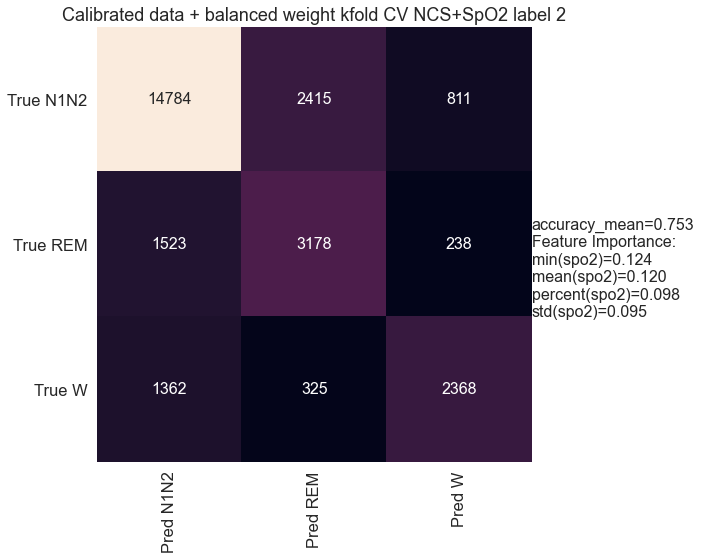

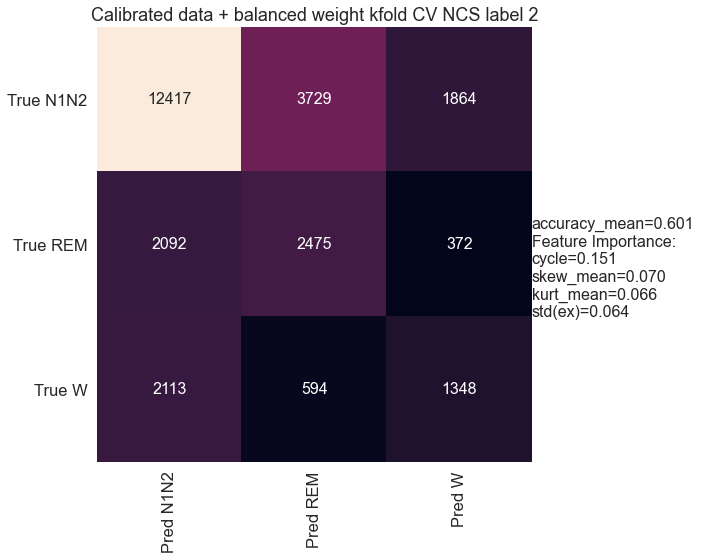

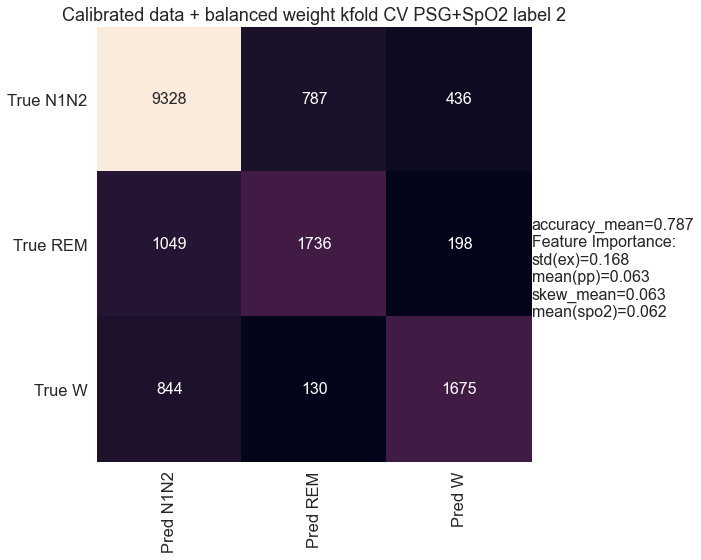

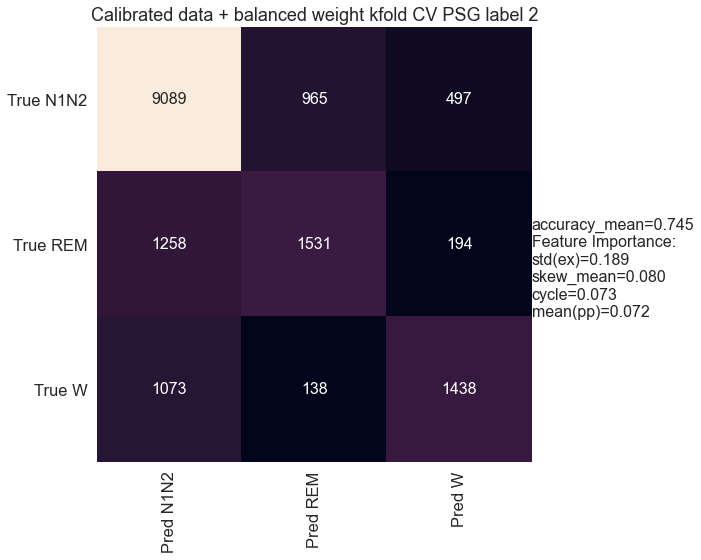

In [20]:
# 3 labels plot 

print(cm1)
CVmethod='Calibrated data + balanced weight kfold'
labelNum=str(2)  #labelling method 1,2,3,4
size=16
name1=["True N1N2","True REM","True W"]
name2=["Pred N1N2","Pred REM","Pred W"]
w=14 #fig size 1      change when label num change
h=8   #fig size 2
a=3   #txt position 1   change when label num change
b=2   #txt position 2
cm=cm1
acc=acc1
feat=feat1
impt=impt1
df_cm = pd.DataFrame(cm, index=name1, columns=name2)
plt.figure()
sn.set(font_scale=1.5)
sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size}) # font size

s01='accuracy_mean={n:.3f}\nFeature Importance:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=acc,n1=feat[0],s1=impt[0],n2=feat[1],s2=impt[1],n3=feat[2],s3=impt[2],n4=feat[3],s4=impt[3])
plt.text(a,b,s01,fontsize=size)
tle=CVmethod+' CV NCS+SpO2 label '+ labelNum
plt.title(tle)
figure = plt.gcf()
figure.set_size_inches(w, h)
plt.savefig(Folder+r"/figPython/"+tle+".png", dpi=300)




cm=cm2
acc=acc2
feat=feat2
impt=impt2
df_cm = pd.DataFrame(cm, index=name1, columns=name2)
plt.figure()
sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size}) # font size
sn.set(font_scale=1.5)
s01='accuracy_mean={n:.3f}\nFeature Importance:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=acc,n1=feat[0],s1=impt[0],n2=feat[1],s2=impt[1],n3=feat[2],s3=impt[2],n4=feat[3],s4=impt[3])
plt.text(a,b,s01,fontsize=size)
tle=CVmethod+' CV NCS label '+ labelNum
plt.title(tle)
figure = plt.gcf()
figure.set_size_inches(w, h)
plt.savefig(Folder+r"/figPython/"+tle+".png", dpi=300)


cm=cm3
acc=acc3
feat=feat3
impt=impt3
df_cm = pd.DataFrame(cm, index=name1, columns=name2)
plt.figure()
sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size}) # font size
sn.set(font_scale=1.5)
s01='accuracy_mean={n:.3f}\nFeature Importance:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=acc,n1=feat[0],s1=impt[0],n2=feat[1],s2=impt[1],n3=feat[2],s3=impt[2],n4=feat[3],s4=impt[3])
plt.text(a,b,s01,fontsize=size)
tle=CVmethod+' CV PSG+SpO2 label '+ labelNum
plt.title(tle)
figure = plt.gcf()
figure.set_size_inches(w, h)
plt.savefig(Folder+r"/figPython/"+tle+".png", dpi=300)


cm=cm4
acc=acc4
feat=feat4
impt=impt4
df_cm = pd.DataFrame(cm, index=name1, columns=name2)
plt.figure()
sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size}) # font size
sn.set(font_scale=1.5)
s01='accuracy_mean={n:.3f}\nFeature Importance:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=acc,n1=feat[0],s1=impt[0],n2=feat[1],s2=impt[1],n3=feat[2],s3=impt[2],n4=feat[3],s4=impt[3])
plt.text(a,b,s01,fontsize=size)
tle=CVmethod+' CV PSG label '+ labelNum
plt.title(tle)
figure = plt.gcf()
figure.set_size_inches(w, h)
plt.savefig(Folder+r"/figPython/"+tle+".png", dpi=300)


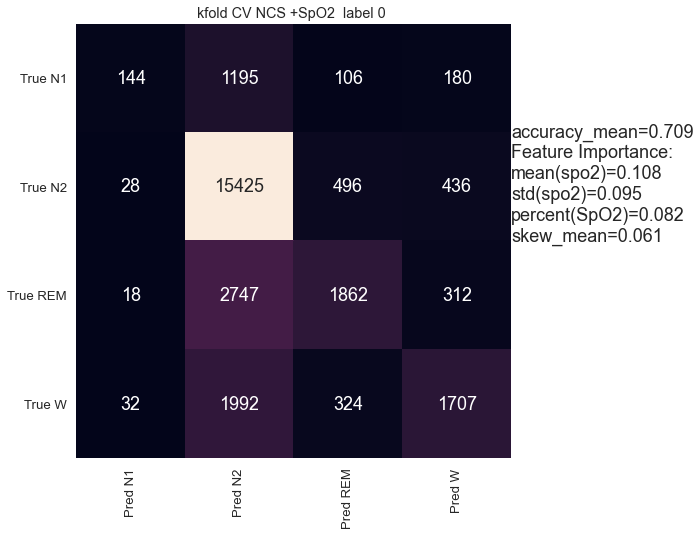

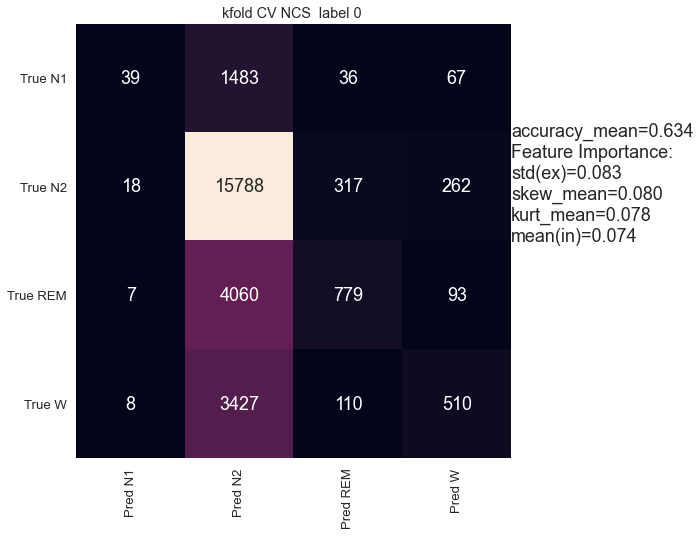

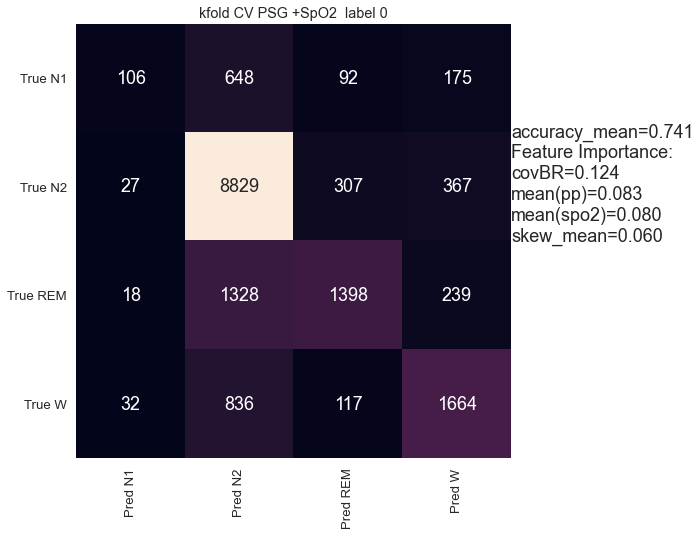

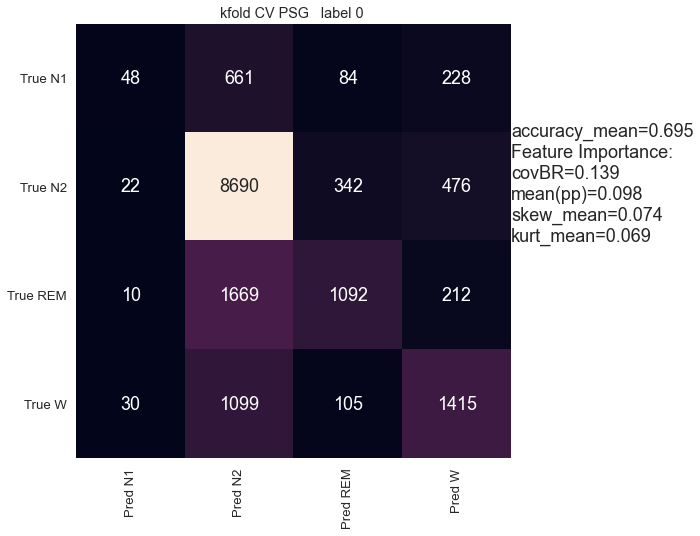

In [17]:
# 4 labels plot 
cm=cm1
acc=acc1
feat=feat1
impt=impt1
size=18
a=4
b=2
w=12
h=8
name1=["True N1","True N2","True REM","True W"]
name2=["Pred N1","Pred N2","Pred REM","Pred W"]
df_cm = pd.DataFrame(cm, index=name1, columns=name2)
plt.figure()
sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size}) # font size
sn.set(font_scale=1.2)
s01='accuracy_mean={n:.3f}\nFeature Importance:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=acc,n1=feat[0],s1=impt[0],n2=feat[1],s2=impt[1],n3=feat[2],s3=impt[2],n4=feat[3],s4=impt[3])
plt.text(a,b,s01,fontsize=size)
plt.title('kfold CV NCS +SpO2  label 0 ')
figure = plt.gcf()
figure.set_size_inches(w, h)
plt.savefig(r'C:\Users\zz587-admin\Documents\sleep center\result\OutputFeat_stage\figPython\NCS+Spo2_kfoldCV_label0.png', dpi=300)


cm=cm2
acc=acc2
feat=feat2
impt=impt2
df_cm = pd.DataFrame(cm, index=name1, columns=name2)

plt.figure()
sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size}) # font size
sn.set(font_scale=1.2)
s02='accuracy_mean={n:.3f}\nFeature Importance:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=acc,n1=feat[0],s1=impt[0],\
    n2=feat[1],s2=impt[1],n3=feat[2],s3=impt[2],n4=feat[3],s4=impt[3])
plt.text(a,b,s02,fontsize=size)
plt.title('kfold CV NCS  label 0 ')
figure = plt.gcf()
figure.set_size_inches(w, h)
plt.savefig(r'C:\Users\zz587-admin\Documents\sleep center\result\OutputFeat_stage\figPython\NCS_kfoldCV_label0.png', dpi=300)


cm=cm3
acc=acc3
feat=feat3
impt=impt3
df_cm = pd.DataFrame(cm, index=name1, columns=name2)
plt.figure()
sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size}) # font size
sn.set(font_scale=1.2)
s01='accuracy_mean={n:.3f}\nFeature Importance:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=acc,n1=feat[0],s1=impt[0],\
    n2=feat[1],s2=impt[1],n3=feat[2],s3=impt[2],n4=feat[3],s4=impt[3])
plt.text(a,b,s01,fontsize=size)
plt.title('kfold CV PSG +SpO2  label 0')
figure = plt.gcf()
figure.set_size_inches(w, h)
plt.savefig(r'C:\Users\zz587-admin\Documents\sleep center\result\OutputFeat_stage\figPython\PSG+Spo2_kfoldCV_label0.png', dpi=300)


cm=cm4
acc=acc4
feat=feat4
impt=impt4
df_cm = pd.DataFrame(cm,index=name1, columns=name2)
plt.figure()
sn.heatmap(df_cm, annot=True,fmt="d",square=True,cbar=False,annot_kws={"size": size}) # font size
sn.set(font_scale=1.2)
s01='accuracy_mean={n:.3f}\nFeature Importance:\n{n1}={s1:.3f}\n{n2}={s2:.3f}\n{n3}={s3:.3f}\n{n4}={s4:.3f}'.format(n=acc,n1=feat[0],s1=impt[0],\
    n2=feat[1],s2=impt[1],n3=feat[2],s3=impt[2],n4=feat[3],s4=impt[3])
plt.text(a,b,s01,fontsize=size)
plt.title('kfold CV PSG   label 0 ')
figure = plt.gcf()
figure.set_size_inches(w, h)
plt.savefig(r'C:\Users\zz587-admin\Documents\sleep center\result\OutputFeat_stage\figPython\PSG_kfoldCV_label0.png', dpi=300)

In [ ]:



data=acc_all1
x = np.arange(len(data))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x+1, data, width, label='accuracy')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('leave one CV NCS')
ax.set_xticks(x)
ax.set_xticklabels(x)
#ax.legend()




fig.tight_layout()


plt.savefig(r'C:\Users\zz587-admin\Documents\sleep center\result\OutputFeat_stage\featureAll\NCS_groupCV.png')

In [ ]:

# present case Num +label count 


data=acc_all1
x = np.arange(len(data))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x+1, data, width, label='accuracy')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('leave one CV NCS')
ax.set_xticks(x)
ax.set_xticklabels(x)
#ax.legend()




fig.tight_layout()


plt.savefig(r'C:\Users\zz587-admin\Documents\sleep center\result\OutputFeat_stage\featureAll\NCS_groupCV.png')